# Adaptative Impedance Controller 

Install the python libraries

In [2]:
from IPython.display import clear_output
from IPython.display import Image


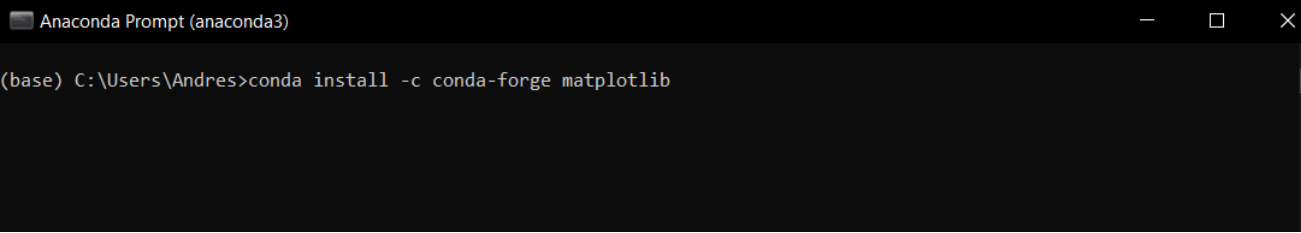

In [3]:
Image(filename='pictures/anacondapromt.png')

In [1]:
import time
import serial         #conda install -c anaconda pyserial
import numpy as np    #conda install -c anaconda numpy
import numpy.linalg as la
from datetime import datetime
import math
import json          #conda install -c jmcmurray json  
from scipy import stats  #conda install -c anaconda scipy
import matplotlib.pyplot as plt  #conda install -c conda-forge matplotlib

Basic control functions

In [ ]:
def star_communication(port):
    ser = serial.Serial(port, 115200, timeout=1)   #Include the number of the serial port
    return ser
    
def motor_control(ser, speed_val):    #speed on the range of +255 to -255, Negative values just open the valve and stop the pump, 0 stops the pump but valve is still working
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_speed=str(speed_val)
    cmd='m'+motor_speed+'\n'
    print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))

def pressure_control(ser, pressure_val):    #pressure on the range of 0 to +25 kpa
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_pressure=str(pressure_val)
    cmd='p'+motor_pressure+'\n'
    print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))
    
def bend_control(ser, bend_val):    #angle on the range of 0 to +180
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_bend=str(bend_val)
    cmd='a'+motor_bend+'\n'
    print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))

def close_communication(ser):
    motor_control(ser,1)
    ser.close()


def read_data(ser):
    #ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.015)
    ser_bytes = ser.readline(ser.inWaiting())
    decoded_bytes = ser_bytes.decode()
    if len(decoded_bytes)>0 :
        decoded_bytes=decoded_bytes.strip()
        separated_data=decoded_bytes.split(",")
        if len(separated_data[0])>=4:
            integer_data = [i for i in separated_data]
            integer_array= np.array(integer_data)
        else:
            integer_array=np.zeros(5)
            integer_array[0]=2000
    else:
        integer_array=np.zeros(5)
        integer_array[0]=2000
    return integer_array

    
def feedback_data(ser):              #current angle, current pressure, set_point(pressure or angle controller depends of the control), motor_speed
    integer_array=read_data(ser)
    while len(integer_array)<5 or integer_array[0]==2000:
        integer_array=read_data(ser)
    integer_array2=integer_array
    return integer_array2




***
$\mathbf{\text{Zero-torque Trajectory}}$<br>
***
1.&emsp;The zero-torque trajectory of the controller, $q_{d}(t)$ followed a minimum-jerk trajectory <br>

$$q_{d}(t) = q_{i} + (q_{f} - q_{i}) \Bigg[ 10 (\frac{t}{D})^3 - 15 (\frac{t}{D})^4 + 6 (\frac{t}{D})^5 \Bigg]   (4)$$

Cite: Equation (4) at Xiong, X., Nah, M. C., Krotov, A., & Sternad, D. (Accepted/In press). Online Impedance Adaptation Facilitates Manipulating a Whip. In Proceedings of the International Conference on Intelligent Robots and Systems (IROS 2021) IEEE.[Link](/References/IROS21_1612_MS.pdf)

Task: Complete the function des_tra(self, t, dt), based on the equation 4 and the input parameters $q_{i}=$self.ini_ang, $q_{f}=$self.end_ang, $D=$self.dur 

In [ ]:
def des_tra(self, t, dt):   ####Trajectory planner### minimum jerk trajectory equation 4 iros2021
        
        
        des_ang =  .....................
        
        deg_vel = (des_ang - self.pre_ang)/dt
        self.pre_ang = np.copy(des_ang)
        return des_ang, deg_vel

***
$\mathbf{\text{Adaptative Motor Controller}}$<br>
***
1.&emsp;The position error $e(t)$, velocity error $\dot{e}(t)$, and tracking error $\varepsilon(t)$ are given by:  <br>

$$e(t)=q(t)-q_{d}(t)$$
$$\dot{e}(t)=\dot{q}(t)-\dot{q}_{d}(t)$$
$$\varepsilon(t)=e(t)+\beta\dot{e}(t)$$

Cite: Equation (3) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222.

Task: Complete the function gen_vel_err(self), gen_track_err(self), based on the equation 3 and the input parameters $q=$self.q, $\dot{q}(t)=$self.dq, <br>
$\dot{q}_{d}(t)=$self.dq_d, $\beta=$self.k


In [ ]:
def gen_pos_err(self):   ## 2018 equ. 3
        #print np.mat(self.arm.q).shape, self.task.ref_traj_ang.shape
        return (self.q - self.q_d)

def gen_vel_err(self):   ## 2018 equ. 3
        #print np.mat(self.arm.dq).shape, self.task.ref_traj_vel.shape
        return (................)

def gen_track_err(self):  ## 2018 equ. 3
        return (................)

2.&emsp;$\gamma(t)$ is an adaptation scalar with the positive scalrs $a$ and $b$, defined as follows:  <br>

$$\gamma(t)=\frac{a}{1+b \mid\mid \varepsilon(t) \mid\mid^2 }$$


Cite: Equation (9) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222.

Task: Complete the function gen_for_factor(self), based on the equation 9 and the input parameters $a=$self.a, $b=$self.b, and $\varepsilon(t)=$gen_track_err()<br>

To calculate the norm of the equation you can use the function la.norm()<br>


In [ ]:
def gen_for_factor(self):  ## 2018 equ. 9  adaptation rate
        return ................)

3.&emsp;The force and impedance adaptation is guided by: <br>

$$F(t)=\frac{\varepsilon(t)}{\gamma(t)}$$
$$K(t)=F(t)e^T(t)$$
$$D(t)=F(t)\dot{e}^T(t)$$



Cite: Equation (8) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222.

Task: Complete the function update_impedance(self, q, q_d, dq, dq_d), based on the equation 8 and the input parameters <br>
$\varepsilon(t)=$gen_track_err(), <br>
$\gamma(t)=$gen_for_factor(), <br>
$e=$gen_pos_err(), <br>
$\dot{e}=$gen_vel_err().  <br>

**To calculate the transposed matrix of the vector you can use the function ndarray.T(), e.g. $e^T(t)=$self.gen_pos_err().T<br>

In [ ]:
def update_impedance(self, q, q_d, dq, dq_d):   ### main function for impedance control equation 8 and 9 in 2018 paper

        self.q = np.mat(np.copy(q)).T
        self.q_d = np.mat(np.copy(q_d)).T

        self.dq = np.mat(np.copy(dq)).T
        self.dq_d = np.mat(np.copy(dq_d)).T

        self.k_mat = ..................

        self.d_mat = ..................

        self.ff_tau_mat = self.gen_track_err() / self.gen_for_factor()

        return self.k_mat, self.d_mat, self.ff_tau_mat


***
$\mathbf{\text{Adaptative impedance controller Class}}$<br>
***

In [ ]:
class ada_imp_con( ):
    def __init__(self, dof):
        self.DOF = dof
        self.k_mat = np.mat(np.zeros((self.DOF, self.DOF)))
        self.d_mat = np.mat(np.zeros((self.DOF, self.DOF)))
        self.ff_tau_mat = np.mat(np.zeros((self.DOF, 1)))

        self.q = np.mat(np.zeros((self.DOF, 1)))
        self.q_d = np.mat(np.zeros((self.DOF, 1)))

        self.dq = np.mat(np.zeros((self.DOF, 1)))
        self.dq_d = np.mat(np.zeros((self.DOF, 1)))
        self.a = 0.2
        self.b = 44000.0#35000.0#5.0
        self.k = 0.05#

        #minimal jerk trajectory
        self.ini_ang = 0.0   #q_i
        self.end_ang = 60.0  #q_f
        self.dur = 2.0       #D
        self.pre_ang = 0.0
        
        
    def des_tra(self, t, dt):   ####Trajectory planner### minimum jerk trajectory equation 4 iros2021
        des_ang = self.ini_ang + ( self.end_ang - self.ini_ang ) * ( 10 * np.power(t,3 ) / ( self.dur ** 3 ) - 15 * np.power(t, 4 ) / ( self.dur ** 4 ) +  6 * np.power( t, 5 ) / ( self.dur ** 5 ) )
        deg_vel = (des_ang - self.pre_ang)/dt
        self.pre_ang = np.copy(des_ang)
        return des_ang, deg_vel
    
    
    def gen_pos_err(self):   ## 2018 equ. 3
      ##Complete ###

    def gen_vel_err(self):   ## 2018 equ. 3
      ##Complete ###

    def gen_track_err(self):  ## 2018 equ. 3
      ##Complete ###

    def gen_for_factor(self):  ## 2018 equ. 9  adaptation rate
      ##Complete ###
    
    def update_impedance(self, q, q_d, dq, dq_d):   ### main function for impedance control equation 8 and 9 in 2018 paper
        self.q = np.mat(np.copy(q)).T
        self.q_d = np.mat(np.copy(q_d)).T
        self.dq = np.mat(np.copy(dq)).T
        self.dq_d = np.mat(np.copy(dq_d)).T

        self.k_mat = ##Complete ###

        self.d_mat = ##Complete ###

        self.ff_tau_mat = self.gen_track_err() / self.gen_for_factor()
        
        return self.k_mat, self.d_mat, self.ff_tau_mat



In [ ]:
# %load scripts/ada_imp_con.py

***
$\mathbf{\text{Demo version: Control loop for soft actuator}}$<br>
***

Initial parameters

In [ ]:
ser=star_communication('COM14')

n_t=0.0                           ## runing time
duration = 30                     ## total process time
pre_t = 0.0                       ##previous time n-1
DOF = 1                           ## control degrees of freedom

ada.end_ang = 120.0               ## maximal point to reach
ada = ada_imp_con(DOF)            ##initialization of the adaptative function
ada.dur = duration                ##duration of the whole trajectory


motor_control(ser,1)              ##enough time for start the pump
time.sleep(5)                     ##enough time for start the pump
motor_val = 0.0                   ##control output to the pump
max_mo_val = 250                  ## saturation value
fb_motor_val = 0.                 ##feedback of the motor speed


values=feedback_data(ser)        ##getting initial position of the robot
in_ang = float(values[0])        ##getting initial position of the robot
now_ang = np.copy(in_ang)        ##getting initial position of the robot
pre_ang = np.copy(in_ang)        ##getting initial position of the robot
now_vel = 0.0                    ##getting initial position of the robot

alp= 0.9                         ##low-pass filter with a low bias from the input constant
ave_ang_err = 0.0                ## angular error angle-desired angle
t_s = 0                          ## sample time
s_t = datetime.now()             ##current initial time

1.&emsp;The $\tau(t)$ produced by the AMC includes the force and impedance parts: <br>

$$\tau(t) = -F(t)-K(t)e(t)-D(t)\dot{e}(t)   (2)$$

Cite: Equation (2) at Xiong, X., Nah, M. C., Krotov, A., & Sternad, D. (Accepted/In press). Online Impedance Adaptation Facilitates Manipulating a Whip. In Proceedings of the International Conference on Intelligent Robots and Systems (IROS 2021) IEEE.

Task: Complete the calculation of $\tau(t)=$fb_motor_val, based on the equation 2 and the input parameters $K=$k[0,0], $D=$d[0,0],the error and velocity error are calculated based on the current angle (now_ang_rad), desired angle (des_ang_rad), current velocity (now_vel_rad), and desired velocity (des_vel_rad).<br>
** e=des_ang_rad-now_ang_rad

In [ ]:
while (n_t < duration ):

    diff_t = datetime.now() - s_t
    n_t = diff_t.seconds + diff_t.microseconds/1E6               ##current process time

    dt = n_t-pre_t                                               ## time for 1 iteration

    des_ang, des_vel = ada.des_tra(n_t, dt)                      ##etting the desired trajectory 
    des_ang = in_ang + des_ang                                   ##initial position compensation (translation pos)

    values=feedback_data(ser)

    now_ang = float(values[0])                                  ##transforming to float value
    now_ang = (alp * pre_ang) + (1.0-alp) * (now_ang)           ##low pass filter 
    if (dt > 0.0):                                              ##avoid undefinition
        now_vel = (now_ang - pre_ang)/dt                        ##calculating the current speed 
    else:
        now_vel = 0.0

    
    now_ang_rad = (now_ang/180.0)*math.pi   ##transforming in radians units  current angle
    des_ang_rad = (des_ang/180.0)*math.pi   ##transforming in radians units  desired angle
    now_vel_rad = (now_vel/180.0)*math.pi   ##transforming in radians units  current speed
    des_vel_rad = (des_vel/180.0)*math.pi   ##transforming in radians units  desired speed
    
    k, d, ff = ada.update_impedance(now_ang_rad, des_ang_rad, now_vel_rad, des_vel_rad)     ##k stifness  d damping  ff not used
    
    fb_motor_val = ###Complete .....###  ##equation 2 2018
    
    print(n_t, des_ang_rad-now_ang_rad)                                                     ##fb_motor_val, k[0,0], d[0,0])#des_ang_rad-now_ang_rad)
    ave_ang_err = ave_ang_err + abs(des_ang_rad-now_ang_rad)                                ##acumulated average error


   
    motor_val = des_ang * 2.5                     ##  feed forward control with constant a=2.5
    motor_val = motor_val + fb_motor_val          ##  feedback control + ff control

    if motor_val > max_mo_val:                    ##  saturation of the motor speed
        motor_val = max_mo_val
        print('out of limit!')
        #break
    motor_control(ser,motor_val)                 ##   asigning the value to the board
    #print(motor_val, fb_motor_val)
    #print(n_t, motor_val, des_ang, des_vel)

    #print(values)
    #print(dt)
    t_s = t_s + 1


    pre_t = np.copy(n_t)                         ##     saving the previous values for time
    pre_ang = np.copy(now_ang)                   ##     saving the previous values for angle

print(ave_ang_err/t_s)                           ##     average error
close_communication(ser)

In [ ]:
%load scripts/acm_control.py